<a href="https://colab.research.google.com/github/FrancescoMonaco/ArcEager/blob/main/NLPProject_2087638.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


---

Library installations and basic imports. \\
Definiton of the Arc Eager algorithm.

In [1]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install evaluate
!pip install transformers
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 5.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset, Dataset

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#@title Arc Eager Model

class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # three shift moves to initialize the stack
    self.shift()
    #self.shift()
    #if len(self.sentence) > 2:
     # self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    o1 = self.stack.pop()
    o2 = self.buffer[0]
    self.arcs[o1] = o2
    #self.stack.append(o1)
    #if len(self.stack) < 2 and len(self.buffer) > 0:
     # self.shift()

  def right_arc(self):
    o1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    o2 = self.stack.pop()
    self.arcs[o1] = o2
    self.stack.append(o2)
    self.stack.append(o1)
    #if len(self.stack) < 2 and len(self.buffer) > 0:
     # self.shift()

  def reduce(self):
    o1 = self.stack.pop()
    #if len(self.stack) < 2 and len(self.buffer) > 0:
     # self.shift()

  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)  


In [4]:
#@title Oracle
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    o1 = self.parser.stack[len(self.parser.stack)-1]
    o2 = self.parser.buffer[0]

    if self.gold[o1] == o2 and self.parser.arcs[o1] != self.gold[o1] and o1 != -1:
      return True
    return False


  def is_right_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    o1 = self.parser.stack[len(self.parser.stack)-1]
    o2 = self.parser.buffer[0]

    #ver = o2 in gold and gold[o2] or -1
    #if ver == o1: return True
   
    if self.gold[o2] != o1:
      return False

    return True
  
  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    
    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False
    
    return True

  def is_reduce_gold(self):
    if len(self.parser.stack) < 2: return False
    o1 = self.parser.stack[-1]
    if self.has_head(o1) and self.has_all_children(o1):
      return True
    return False

  def has_head(self, node):
    if self.parser.arcs[node] != -1: return True
    else: return False

  def has_all_children(self, node):
    i = 0
    for arc in self.gold:
      if arc == node:
        if self.parser.arcs[i] != node:
          return False
      i+=1
    return True 

In [5]:
#@title Example of the model working
sentence = ['<ROOT>','Non', 'soltanto', 'perché', 'oggi', 'come', 'allora', 'la', 'falce', 'è', 'cieca', ',', 'si', 'abbatte', 'indistintamente', 'su', 'uomini', ',', 'donne', 'e', 'bambini', '.']#["<ROOT>", "He", "began", "to", "write", "again", "."]
gold =[-1, 2, 0, 10, 10, 6, 4, 8, 10, 10, 2, 13, 13, 10, 13, 16, 13, 18, 16, 20, 16, 2]#[-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

while not parser.is_tree_final():  
  if oracle.is_left_arc_gold():
    parser.left_arc()
  elif oracle.is_right_arc_gold():
    parser.right_arc()
  elif oracle.is_reduce_gold():  
    parser.reduce()
  elif oracle.is_shift_gold():  
    parser.shift()

print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Reduce: ", oracle.is_reduce_gold())
print("Shift: ", oracle.is_shift_gold())



print('Parsed:', parser.arcs)
print('Gold:',gold)

Left Arc:  False
Right Arc:  False
Reduce:  False
Shift:  False
Parsed: [-1, 2, 0, 10, 10, 6, 4, 8, 10, 10, 2, 13, 13, 10, 13, 16, 13, 18, 16, 20, 16, 2]
Gold: [-1, 2, 0, 10, 10, 6, 4, 8, 10, 10, 2, 13, 13, 10, 13, 16, 13, 18, 16, 20, 16, 2]


In [6]:
#@title Util functions for projective trees and dictionary

# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False
  
  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['new_tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1 

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1 
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [7]:
#@title Util functions for mini-batches and sample processing

def prepare_batch(batch_data, get_gold_path=False, is_transformer=False):
  data = [process_sample(s, get_gold_path=get_gold_path, is_transformer = is_transformer) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

def process_sample(sample, get_gold_path = False, is_transformer = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["new_tokens"]
  gold = [-1] + [int(i) for i in sample["new_head"]]  #heads in the gold tree are strings, we convert them to int
  
  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      
      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])  
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():  
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)

  if is_transformer is False:
    return enc_sentence, gold_path, gold_moves, gold
  else:
   return enc_sentence, gold_path, gold_moves, gold , sample["input_ids"], sample["labels"]

# Dataset analysis and data extraction

---



Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13121 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/564 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/482 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/it_isdt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


Dataset lenght: 14167
Keys:  dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])


Text(0.5, 1.0, 'Sentence lenght distribution')

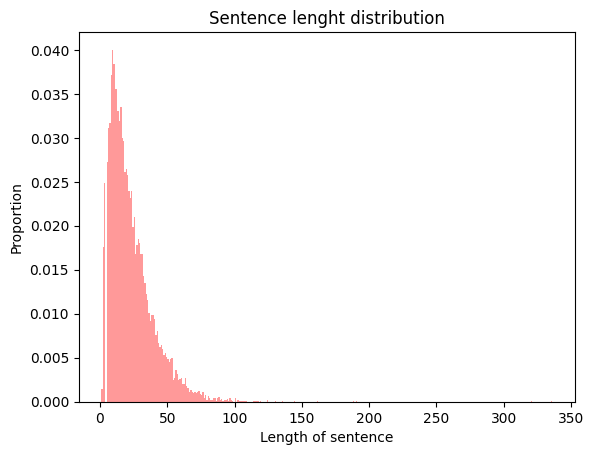

In [8]:
#@title Retrieve the dataset, show relevant informations
train_dataset = load_dataset('universal_dependencies', 'it_isdt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'it_isdt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'it_isdt', split="test")

# info about dataset
print("Dataset lenght:", len(train_dataset)+len(dev_dataset)+len(test_dataset))
print("Keys: ", train_dataset[1].keys())

sent_len = [len(sentence) for sentence in train_dataset['tokens']]
plt.hist(sent_len, bins=range(min(sent_len), max(sent_len) + 1, 1), 
              alpha=0.4, color="red", density=True, stacked=True)
plt.xlabel("Length of sentence")
plt.ylabel("Proportion")
plt.title("Sentence lenght distribution")

In [9]:
from collections import Counter
counter_len = Counter(sent_len)
print("Sentence length with max probability:", counter_len.most_common(1)[0][0])
del counter_len, sent_len

Sentence length with max probability: 9


In [10]:
#@title Extraction

# remove 'None' values in the heads list due to the tokenization
# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
def fillNone(x):
  x['new_head'] = []
  x['new_tokens'] = []
  for index, elem in enumerate(x['head']):
    if elem != 'None': 
      x['new_head'].append(elem)
      x['new_tokens'].append(x['tokens'][index])

  return x
train_dataset = train_dataset.map(fillNone)
dev_dataset = dev_dataset.map(fillNone)
test_dataset = test_dataset.map(fillNone)
train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["new_head"]])] 

# create the embedding dictionary 
emb_dictionary = create_dict(train_dataset)

print("***Number of samples***")
print("Train (filtered):\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Map:   0%|          | 0/13121 [00:00<?, ? examples/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

***Number of samples***
Train (filtered):	 12954
Dev:	 564
Test:	 482


In [11]:
train_dataset[3]

{'idx': 'isst_tanl-5',
 'text': 'Inconsueto allarme alla Tate Gallery:',
 'tokens': ['Inconsueto',
  'allarme',
  'alla',
  'a',
  'la',
  'Tate',
  'Gallery',
  ':'],
 'lemmas': ['inconsueto', 'allarme', '_', 'a', 'il', 'Tate', 'Gallery', ':'],
 'upos': [6, 0, 13, 2, 8, 10, 10, 1],
 'xpos': ['A', 'S', None, 'E', 'RD', 'SP', 'SP', 'FC'],
 'feats': ["{'Gender': 'Masc', 'Number': 'Sing'}",
  "{'Gender': 'Masc', 'Number': 'Sing'}",
  'None',
  'None',
  "{'Definite': 'Def', 'Gender': 'Fem', 'Number': 'Sing', 'PronType': 'Art'}",
  'None',
  'None',
  'None'],
 'head': ['2', '0', 'None', '5', '5', '2', '5', '2'],
 'deprel': ['amod', 'root', '_', 'case', 'det', 'nmod', 'flat:name', 'punct'],
 'deps': ["[('amod', 2)]",
  "[('root', 0)]",
  'None',
  "[('case', 5)]",
  "[('det', 5)]",
  "[('nmod:a', 2)]",
  "[('flat:name', 5)]",
  "[('punct', 2)]"],
 'misc': ['None',
  'None',
  'None',
  'None',
  'None',
  'None',
  "{'SpaceAfter': 'No'}",
  'None'],
 'new_head': ['2', '0', '5', '5', '2', '

###Analysis
The complete dataset is composed of 14167 samples. \\
The train dataset is composed of 12954 filtered samples, after removing 167 samples that were non-projective. \\
As shown in the plot above the most common lenght of a sample is 9 tokens.



#Models

---



## Baseline LSTM

In [ ]:
#@title Parameters
EMBEDDING_SIZE = 300 #@param {type:"integer"}
LSTM_SIZE = 300 #@param {type:"integer"}
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15 #@param {type:"integer"}
LR = 0.001   # learning rate
BATCH_SIZE = 16 #@param {type:"slider", min:16, max:64, step:2}

In [ ]:
#@title Dataloaders for the NN
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

In [ ]:
#@title Model
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])
    
    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)
  
  
  def forward(self, x, paths):
    # get the embeddings 
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence 
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step 
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])  
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
      moves_argm = moves.argmax(-1)
      for i in range(len(parsers)):
          if parsers[i].is_tree_final():
              continue
          else:
              # Left arc
              if moves_argm[i] == 0:
                  stack_len = len(parsers[i].stack)
                  if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                      parsers[i].left_arc()
                  else:
                    if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                    else: 
                      parsers[i].shift()
          
              # Right arc
              elif moves_argm[i] == 1:
                  stack_len = len(parsers[i].stack)
                  if stack_len >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                  else:
                      if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                      elif len(parsers[i].stack) >= 2:
                        parsers[i].reduce()
                      else: 
                        parsers[i].shift()
            
              # Shift
              elif moves_argm[i] == 2:
                  if len(parsers[i].buffer) > 0:
                      parsers[i].shift()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                  
              # Reduce
              elif moves_argm[i] == 3:
                  if len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    else:
                      parsers[i].shift()


      '''
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:
          if parsers[i].stack[len(parsers[i].stack)-2] != 0:
            parsers[i].left_arc()
          else:
            if len(parsers[i].buffer) > 0:
              parsers[i].shift()
            else:
              parsers[i].right_arc()
        elif moves_argm[i] == 1:
          if parsers[i].stack[len(parsers[i].stack)-2] == 0 and len(parsers[i].buffer)>0:
            parsers[i].shift()
          else:
            parsers[i].right_arc()
        elif moves_argm[i] == 2:
          if len(parsers[i].buffer) > 0:
            parsers[i].shift()
          else:
            if moves[i][0] > moves[i][1]:
              if parsers[i].stack[len(parsers[i].stack)-2] != 0:
                parsers[i].left_arc()
              else:
                parsers[i].right_arc()
            else:
              parsers[i].right_arc()
        elif moves_argm[i] == 3:
           parsers[i].reduce()
           pass
           '''

In [ ]:
#@title Functions for training and evaluation

# Evaluation
def evaluate(gold, preds): 
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

# Training
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
  
  return total_loss/count

# Testing
def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred
  
  return evaluate(gold, preds)

In [ ]:
#@title Train
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 0.915 | dev_uas: 0.691 |
Epoch:   1 | avg_train_loss: 0.863 | dev_uas: 0.729 |
Epoch:   2 | avg_train_loss: 0.846 | dev_uas: 0.745 |
Epoch:   3 | avg_train_loss: 0.835 | dev_uas: 0.760 |
Epoch:   4 | avg_train_loss: 0.829 | dev_uas: 0.769 |
Epoch:   5 | avg_train_loss: 0.823 | dev_uas: 0.777 |
Epoch:   6 | avg_train_loss: 0.819 | dev_uas: 0.784 |
Epoch:   7 | avg_train_loss: 0.816 | dev_uas: 0.784 |
Epoch:   8 | avg_train_loss: 0.813 | dev_uas: 0.785 |
Epoch:   9 | avg_train_loss: 0.810 | dev_uas: 0.791 |
Epoch:  10 | avg_train_loss: 0.808 | dev_uas: 0.791 |
Epoch:  11 | avg_train_loss: 0.806 | dev_uas: 0.795 |
Epoch:  12 | avg_train_loss: 0.805 | dev_uas: 0.793 |
Epoch:  13 | avg_train_loss: 0.803 | dev_uas: 0.797 |
Epoch:  14 | avg_train_loss: 0.802 | dev_uas: 0.796 |


In [ ]:
#@title Save the model?
i = "No" #@param ["Yes", "No"]
if i == 'Yes':
  from google.colab import files
  torch.save(model.state_dict(), 'checkpoint.pth')

  # download checkpoint file
  files.download('checkpoint.pth')

# To retreive the model
#state_dict = torch.load('checkpoint.pth')
#model.load_state_dict(state_dict)

## BERT

In [12]:
#@title Parameters
MLP_SIZE = 200
DROPOUT = 0.2
EMBEDDING_SIZE = 300 #@param {type:"integer"}
EPOCHS = 15 #@param {type:"integer"}
LR = 0.001   # learning rate
BATCH_SIZE = 16 #@param {type:"slider", min:16, max:64, step:2}
OUT_FEATURES = 768

In [13]:
#@title Class
from transformers import BertModel, TrainingArguments, Trainer, AutoTokenizer, DataCollatorWithPadding
class BERTNet(nn.Module):

  def __init__(self, device):
    super(BERTNet, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])
    
    # initialize bi-LSTM
    self.bert = BertModel.from_pretrained("bert-base-multilingual-uncased")

    # initialize feedforward
    self.w1 = torch.nn.Linear(OUT_FEATURES, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)
  
  
  def forward(self, x, paths):
    # get the embeddings 
    #x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run BERT
    h = self.bert_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of BERT the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def bert_pass(self, x):
    #x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h = self.bert(x) # returns (batch, len_sent, hid)
    h = h.permute(1,0,2)
    #h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*OUT_FEATURES, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence 
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step 
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.bert_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])  
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
      moves_argm = moves.argmax(-1)
      for i in range(len(parsers)):
          if parsers[i].is_tree_final():
              continue
          else:
              # Left arc
              if moves_argm[i] == 0:
                  stack_len = len(parsers[i].stack)
                  if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                      parsers[i].left_arc()
                  else:
                    if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                    else: 
                      parsers[i].shift()
          
              # Right arc
              elif moves_argm[i] == 1:
                  stack_len = len(parsers[i].stack)
                  if stack_len >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                  else:
                      if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                      elif len(parsers[i].stack) >= 2:
                        parsers[i].reduce()
                      else: 
                        parsers[i].shift()
            
              # Shift
              elif moves_argm[i] == 2:
                  if len(parsers[i].buffer) > 0:
                      parsers[i].shift()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                  
              # Reduce
              elif moves_argm[i] == 3:
                  if len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    else:
                      parsers[i].shift()

In [14]:
#@title Functions for training and evaluation

# Evaluation
def evaluate_tr(gold, preds): 
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

# Training
def train_tr(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
   # _, _, _, _, _, _, _, _, _, _, _, _, _, input_ids, attention_mask, labels = batch
    sentences, paths, moves, trees, indices_ids, labels_pad = batch

    out = model(indices_ids, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
  
  return total_loss/count

# Testing
def test_tr(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred
  
  return evaluate_tr(gold, preds)

In [ ]:
#@title Wandb setup
Use_Wandb = False #@param {type:"boolean"}
if Use_Wandb:
  !pip install wandb
  import wandb
  %env WANDB_PROJECT=BERT_parsing
  wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=2b32ad0effcc67461973fff2c0723bc962d5cb0ec967bfcbf0a6eaf13a33539a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
env: WANDB_PROJECT=BERT_parsing


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [23]:
#@title Util function for tokenization
def tokenize_and_align_labels(example):

    example['new_head'] = []
    example['new_tokens'] = []
    for index, elem in enumerate(example['head']):
      if elem != 'None': 
        example['new_head'].append(elem)
        example['new_tokens'].append(example['tokens'][index])

    tokens = example["new_tokens"]
    heads = example["new_head"]

    # Tokenize the tokens using BERT tokenizer
    tokenized_inputs = tokenizer(tokens, truncation=True, is_split_into_words=True)
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']

    # Initialize label list with -100 for all tokens
    labels = [-100] * len(input_ids)

    # Assign labels to the first token of each word
    word_ids = tokenized_inputs.word_ids()
    for i, word_id in enumerate(word_ids):
        if word_id is not None:
            labels[word_id] = heads[i]

    # Create the dictionary for the transformed example
    transformed_example = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
       # ,'new_tokens': tokens,
        #'new_head': heads
    }

    return transformed_example

train_dataset = load_dataset('universal_dependencies', 'it_isdt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'it_isdt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'it_isdt', split="test")

In [16]:
#@title Setup 
import evaluate

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased") 

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt', padding = True)

In [24]:
#@title Data Preparation
train_dataset = train_dataset.map(tokenize_and_align_labels)
dev_dataset = dev_dataset.map(tokenize_and_align_labels)
test_dataset = test_dataset.map(tokenize_and_align_labels)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, collate_fn = data_collator)

Map:   0%|          | 0/13121 [00:00<?, ? examples/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:578 in wrapper                 │
│                                                                                                  │
│    575 │   │   else:                                                                             │
│    576 │   │   │   self: "Dataset" = kwargs.pop("self")                                          │
│    577 │   │   # apply actual function                                                           │
│ ❱  578 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    579 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    580 │   │   for dataset in datasets:                                                          │
│    581 │   │   │   # Remove task templates if a column mapping of the template is no longer val  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:543 in wrapper                 │
│                                                                                                  │
│    540 │   │   │   "output_all_columns": self._output_all_columns,                               │
│    541 │   │   }                                                                                 │
│    542 │   │   # apply actual function                                                           │
│ ❱  543 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    544 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    545 │   │   # re-apply format to the output                                                   │
│    546 │   │   for dataset in datasets:                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:3073 in map                    │
│                                                                                                  │
│   3070 │   │   │   │   │   leave=False,                                                          │
│   3071 │   │   │   │   │   desc=desc or "Map",                                                   │
│   3072 │   │   │   │   ) as pbar:                                                                │
│ ❱ 3073 │   │   │   │   │   for rank, done, content in Dataset._map_single(**dataset_kwargs):     │
│   3074 │   │   │   │   │   │   if done:                                                          │
│   3075 │   │   │   │   │   │   │   shards_done += 1                                              │
│   3076 │   │   │   │   │   │   │   logger.debug(f"Finished processing shard number {rank} of {n  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:3427 in _map_single            │
│                                                                                                  │
│   3424 │   │   │   │   if not batched:                                                           │
│   3425 │   │   │   │   │   _time = time.time()                                                   │
│   3426 │   │   │   │   │   for i, example in shard_iterable:                                     │
│ ❱ 3427 │   │   │   │   │   │   example = apply_function_on_filtered_inputs(example, i, offset=o  │
│   3428 │   │   │   │   │   │   if update_data:             

In [ ]:
#@title Training
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
transformer = BERTNet(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=LR)
transformer.to(device)

for epoch in range(EPOCHS):
  avg_train_loss = train_tr(transformer, train_dataloader, criterion, optimizer)
  val_uas = test_tr(transformer, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 9>:10                                                                             │
│ in train_tr:22                                                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:633 in __next__           │
│                                                                                                  │
│    630 │   │   │   if self._sampler_iter is None:                                                │
│    631 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    632 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  633 │   │   │   data = self._next_data()                                                      │
│    634 │   │   │   self._num_yielded += 1                                                        │
│    635 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    636 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:677 in _next_data         │
│                                                                                                  │
│    674 │                                                                                         │
│    675 │   def _next_data(self):                                                                 │
│    676 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  677 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    678 │   │   if self._pin_memory:                                                              │
│    679 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    680 │   │   return data                                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py:54 in fetch             │
│                                                                                                  │
│   51 │   │   │   │   data = [self.dataset[idx] for idx in possibly_batched_index]                │
│   52 │   │   else:                                                                               │
│   53 │   │   │   data = self.dataset[possibly_batched_index]                                     │
│ ❱ 54 │   │   return self.collate_fn(data)                                                        │
│   55                                                                                             │
│ in prepare_batch:4                                                                               │
│ in <listcomp>:4                                                                                  │
│ in process_sample:40                                                                             │
│ in is_left_arc_gold:8                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
if Use_Wandb:
  wandb.finish()

In [ ]:
#@title Save the model?
i = "No" #@param ["Yes", "No"]
if i == 'Yes':
  from google.colab import files
  torch.save(trasnformer.state_dict(), 'checkpoint.pth')

  # download checkpoint file
  files.download('checkpoint.pth')

# To retreive the model
#state_dict = torch.load('checkpoint.pth')
#model.load_state_dict(state_dict)

# Evaluation

---



In [ ]:
#@title BiLSTM evaluation
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.796


In [ ]:
#@title BERT evaluation
test_predictions = trainer.predict(mrpc_dataset["test"])
print(test_predictions.metrics)

In [ ]:
#@title BERT error analysis

# Discussion

---

